In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nnfs
from nnfs.datasets import spiral_data
import random
import requests
from NNS import NeuralNetwork as NN #import neural net code from github to reduce copy/pasting
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier

# Binary Logistic Regression

## Sigmoid Activation Function
Gives a range between 0 and 1

In [1]:
# Sigmoid Activation
class Activate_Sigmoid:
    
    #Forward Pass
    def forward(self, inputs):
        # Save input and calculate/save output of sigmoid function
        self.inputs = inputs
        self.output = 1/(1+np.exp(-inputs))
            
    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

## Binary Cross-Entropy Loss

In [20]:
#Common Loss Class
class Loss:
    def calculate(self, output, y):
        #calculate sample losses
        sample_losses = self.forward(output,y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        
        return data_loss
    
    # Regularization loss calculation
    def regularization_loss(self, layer):
        
        # 0 by default
        regularization_loss = 0
        
        # L1 regularization - weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        
        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        # L1 regularization - biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        
        return regularization_loss

class Loss_BinaryCrossentropy(Loss):
    
    # Forward Pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
        
        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        return sample_losses
    
    #Backward Pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        outputs = len(dvalues[0])
        
        # Clip the data to prevent division by 0
        clipped_dvalues = np.clip(dvalues, 1e-7 , 1 - 1e-7 )
        
        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues - 
                        (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normailize gradient
        self.dinputs = self.dinputs / samples
    
    
    

## Integration

In [ ]:
# Create dataset
# 2 classes now since we have binary outputs
X, y = spiral_data( samples = 100 , classes = 2 )
y = y.reshape(-1,1) # Reshape to be a list of lists

dense1 = NN.Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = NN.Activation_ReLU()
dense2 = NN.Layer_Dense(64,1)
activation2 = Activate_Sigmoid()
loss_activation = Loss_BinaryCrossentropy()
optimizer = NN.Optimizer_Adam(decay=5e-7)

for epoch in tqdm(range(10001)):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    data_loss = loss_activation.calculate(activation2.output, y)
    regularization_loss = loss_activation.regularization_loss(dense1) + loss_activation.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    
    predictions = (activation2.output > 0.5) * 1 # Manually select predictions, maybe look at making this a part of the class
    accuracy = np.mean(predictions == y)
    
    # Backward pass
    loss_activation.backward(activation2.output, y)
    activation2.backward(loss_activation.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    # Validate the model
    #Create test dataset
    X_test, y_test = spiral_data(samples=100, classes=2)
    y_test = y_test.reshape(-1,1)
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    validation_data_loss = loss_activation.calculate(activation2.output, y_test)
    validation_regularization_loss = loss_activation.regularization_loss(dense1) + loss_activation.regularization_loss(dense2)
    validation_loss = validation_data_loss + validation_regularization_loss
    validation_predictions =  (activation2.output > 0.5) * 1
    validation_accuracy = np.mean(validation_predictions==y_test)
    
    if not epoch % 1000:
        print(  f'epoch: {epoch}, ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f}, ' +
                f'reg_loss: {regularization_loss :.3f}), ' +
                f'lr: {optimizer.current_learning_rate}, ' +
                f'validation, acc: {validation_accuracy: .3f} , loss: {validation_loss: .3f}' )

  1%|          | 118/10001 [00:00<00:16, 591.47it/s]

epoch: 0, acc: 0.465 , loss: 0.693 (data_loss: 0.693, reg_loss: 0.000), lr: 0.001, validation, acc:  0.500 , loss:  0.693


 11%|█▏        | 1140/10001 [00:01<00:12, 685.88it/s]

epoch: 1000, acc: 0.780 , loss: 0.565 (data_loss: 0.541, reg_loss: 0.025), lr: 0.0009995002498750624, validation, acc:  0.700 , loss:  0.637


 21%|██        | 2084/10001 [00:03<00:11, 668.86it/s]

epoch: 2000, acc: 0.885 , loss: 0.431 (data_loss: 0.373, reg_loss: 0.058), lr: 0.0009990009990009992, validation, acc:  0.740 , loss:  0.567


 31%|███▏      | 3149/10001 [00:04<00:10, 671.53it/s]

epoch: 3000, acc: 0.910 , loss: 0.365 (data_loss: 0.292, reg_loss: 0.072), lr: 0.0009985022466300548, validation, acc:  0.880 , loss:  0.422


 41%|████      | 4051/10001 [00:06<00:11, 511.95it/s]

epoch: 4000, acc: 0.930 , loss: 0.326 (data_loss: 0.252, reg_loss: 0.074), lr: 0.000998003992015968, validation, acc:  0.810 , loss:  0.459


 50%|█████     | 5039/10001 [00:08<00:09, 542.32it/s]

epoch: 5000, acc: 0.935 , loss: 0.293 (data_loss: 0.221, reg_loss: 0.072), lr: 0.0009975062344139652, validation, acc:  0.870 , loss:  0.397


 61%|██████    | 6074/10001 [00:10<00:08, 470.59it/s]

epoch: 6000, acc: 0.950 , loss: 0.263 (data_loss: 0.191, reg_loss: 0.072), lr: 0.0009970089730807579, validation, acc:  0.885 , loss:  0.368


 71%|███████   | 7071/10001 [00:12<00:06, 443.74it/s]

epoch: 7000, acc: 0.950 , loss: 0.243 (data_loss: 0.172, reg_loss: 0.071), lr: 0.000996512207274539, validation, acc:  0.870 , loss:  0.393


 81%|████████  | 8075/10001 [00:14<00:03, 589.19it/s]

epoch: 8000, acc: 0.955 , loss: 0.228 (data_loss: 0.160, reg_loss: 0.068), lr: 0.00099601593625498, validation, acc:  0.900 , loss:  0.346


 91%|█████████ | 9071/10001 [00:16<00:01, 528.17it/s]

epoch: 9000, acc: 0.950 , loss: 0.216 (data_loss: 0.151, reg_loss: 0.065), lr: 0.0009955201592832257, validation, acc:  0.890 , loss:  0.403


100%|██████████| 10001/10001 [00:18<00:00, 548.02it/s]

epoch: 10000, acc: 0.950 , loss: 0.205 (data_loss: 0.144, reg_loss: 0.061), lr: 0.0009950248756218907, validation, acc:  0.900 , loss:  0.358


c:\Users\ethan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


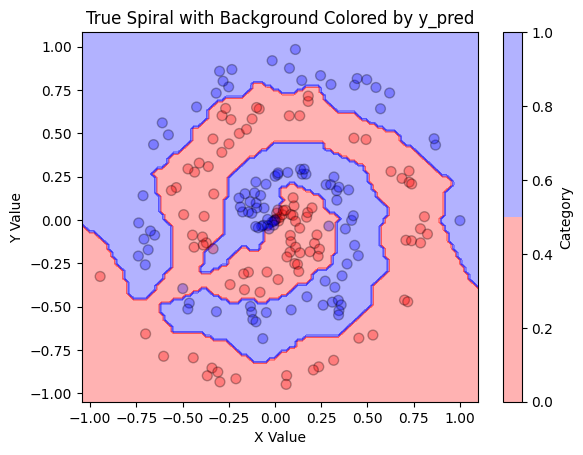

In [31]:
#  Create a meshgrid for the plot background
x_min, x_max = X[:, 0].min() -0.1 , X[:, 0].max() +0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Step 2: Predict the category for each point in the meshgrid based off of y_pred
# Using the nearest neighbors
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, predictions)

# Predict categories for the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions back to the grid shape
Z = Z.reshape(xx.shape)

# Create the background color plot
cmap = ListedColormap(['red', 'blue'])  # Assign colors for each category
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)  # Fill the regions with color

# Plot the scatter plot, 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha = 0.3)

# Add color bar to indicate values of y_pred
plt.colorbar(label='Category')

# Add labels and title
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('True Spiral with Background Colored by y_pred')

# Show the plot
plt.show()